In [1]:
import re
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from collections import Counter

sns.set_theme(style="darkgrid")

import spacy
import textstat
import textblob
import nltk
import string


In [2]:
#pip install Counter
#pip install collections-extended
#pip install spacy
#pip install textstat
#pip install textblob
#pip install nltk
#pip install googletrans

In [3]:
# import jsons
def json2dict(path):
    x = pd.read_json(path)
    return dict(zip(x['id'], x['name']))

pbooktitlefull = json2dict('pbooktitlefull.json')
pjournal = json2dict('pjournal.json')
pjournalfull = json2dict('pjournalfull.json')
ptype = json2dict('ptype.json')


# import csvs
dblp = pd.DataFrame()
for i in range(1, 5):
    csv = pd.read_csv(f'dblp-{i}.csv')
    dblp = pd.concat([dblp, csv]).reset_index(drop=True)
    
test_hidden = pd.read_csv('test_hidden.csv')
train = pd.read_csv('train.csv')
validation_hidden = pd.read_csv('validation_hidden.csv')


In [4]:
dblp.head(5)

,Unnamed: 0,pauthor,peditor,ptitle,pyear,paddress,ppublisher,pseries,pid,pkey,ptype_id,pjournal_id,pbooktitle_id,pjournalfull_id,pbooktitlefull_id,partition
0,4,Jorge Semião|Juan J. Rodríguez-Andina|Fabian V...,NaN,Improving the Tolerance of Pipeline Based Circ...,-2007,NaN,NaN,NaN,180843,conf/dft/SemiaoRVSTT07,1,0,4,0,4,1
1,7,Patrice Caire,NaN,A Normative Multi-Agent Systems Approach to th...,-2007,NaN,NaN,NaN,162991,conf/dagstuhl/Caire07,2,0,7,0,7,1
2,10,Sundeep B|Andrew Thangaraj,NaN,Self-Orthogonality of q-Ary Images of qm-Ary C...,2007,NaN,NaN,NaN,2261406,journals/tit/BT07,0,2,9,2,9,1
3,18,Gerardo Pardo-Castellote,NaN,OMG Data-Distribution Service: Architectural O...,-2003,NaN,NaN,NaN,349720,conf/icdcsw/Pardo-Castellote03,1,0,11,0,11,1
4,19,Ki-Hoon Lee|Kyu-Young Whang|Wook-Shin Han|Min-...,NaN,Structural Consistency: Enabling XML Keyword S...,2009,NaN,NaN,NaN,1922328,journals/corr/abs-0911-4329,3,5,5,5,5,1


In [5]:
dblp.shape

(17165, 16)

In [6]:
dblp[ dblp['pyear']<0 ].shape
#7045 out of 17165 are negative

(7045, 16)

In [7]:
dblp.dtypes

Unnamed: 0             int64
pauthor               object
peditor              float64
ptitle                object
pyear                  int64
paddress             float64
ppublisher            object
pseries               object
pid                    int64
pkey                  object
ptype_id               int64
pjournal_id            int64
pbooktitle_id          int64
pjournalfull_id        int64
pbooktitlefull_id      int64
partition              int64
dtype: object

In [8]:
dblp.isnull().sum()

Unnamed: 0               0
pauthor                  0
peditor              17165
ptitle                   0
pyear                    0
paddress             17165
ppublisher           17148
pseries              17160
pid                      0
pkey                     0
ptype_id                 0
pjournal_id              0
pbooktitle_id            0
pjournalfull_id          0
pbooktitlefull_id        0
partition                0
dtype: int64

The columns peditor and paddress only have null values. Almost all values from pseries and ppublisher are null.

#### Drop selected columns
The columns editor and address only have null values. Almost all values from series and publishers are null. So we drop these columns(not sure about it because it may not be the case for a different dataset). 

In [9]:
df= dblp.drop(['paddress','pseries','ppublisher','peditor'],axis=1)

#### Change the negative years

In [10]:
dblp['pyear'] = dblp['pyear'].apply(lambda x: abs(x))

In [11]:
dblp[ dblp['pyear']<0 ].shape

(0, 16)

#### Find '|' in strings

In [12]:
is_multiAuthor = lambda s: len(re.findall(r'[|]', s))>0

In [13]:
dblp['pauthor'].apply(is_multiAuthor).sum()

12991

In [14]:
len(dblp[dblp['ptitle'].apply(is_multiAuthor)])

2793

#### cound words

In [15]:
cound_words = lambda s: len(re.findall(r'\w+', s))

#### Swap
Assuming that Multiple authors are separated by | and there are no '|' in titles
(maybe that's not the case)

In [16]:
def switch(df):
    for i, row in df.iterrows():
        if (is_multiAuthor(df.iloc[i]['ptitle']) == True) or (is_multiAuthor(df.iloc[i]['pauthor']) == False and cound_words(df.iloc[i]['pauthor']) > 4):
            tmp = df.loc[i,'ptitle']
            df.loc[i,'ptitle'] = df.loc[i,'pauthor']
            df.loc[i,'pauthor'] = tmp
    return(df)

In [17]:
df=switch(df)

In [18]:
df['ptitle'].apply(is_multiAuthor).sum()

1

In [19]:
len(df['ptitle'].unique()) # 17113 out of 17165 titles are unique

17113

In [20]:
len(df['pauthor'].unique()) # 16028 out of 17165 authors are unique

16028

In [21]:
# Small EDA function
def quick_eda(data):
    '''
    Small function to show: missing values, Pairs correlations, and heatmap correlations
    '''
    
    # showing the missing values
#     msno.bar(data)
    
    # showing the Pairs correlations
    plt.figure(figsize=(15,6))
    sns.pairplot(data)
    plt.show()
    
    # Showing the R2 heatmap correlations
    plt.figure(figsize=(15,6))
    sns.heatmap(data.corr(), cmap='RdBu_r', vmax=1, vmin=-1, annot=True)
    plt.suptitle('PEARSON CORRELATIONS')
    plt.show()
    
      # Showing the spearman heatmap correlations
    plt.figure(figsize=(15,6))
    sns.heatmap(data.corr(method='spearman'), cmap='RdBu_r', vmax=1, vmin=-1, annot=True)
    plt.suptitle('SPEARMAN CORRELATIONS')
    plt.show()


<Figure size 1080x432 with 0 Axes>

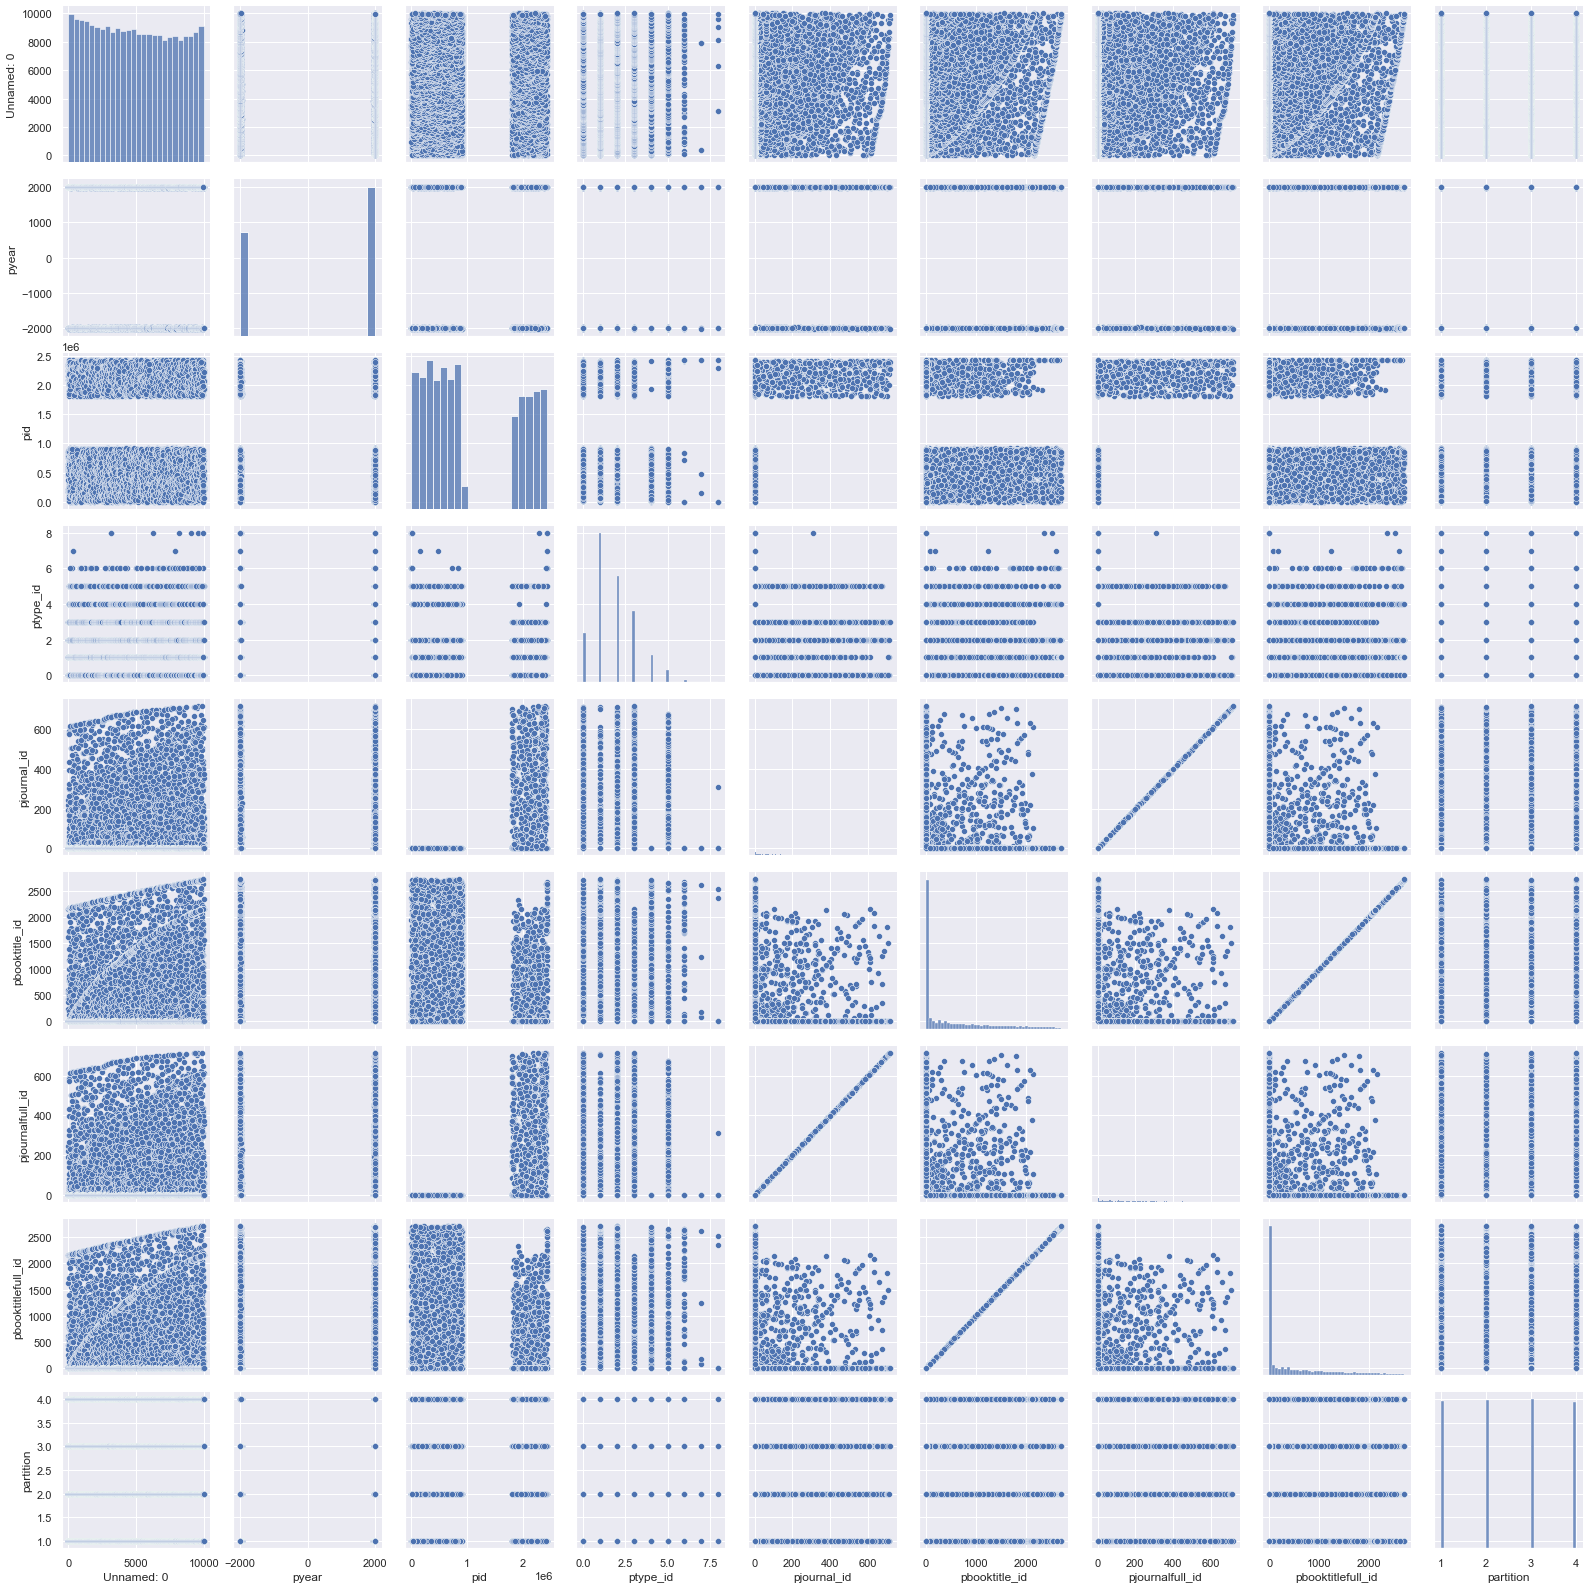

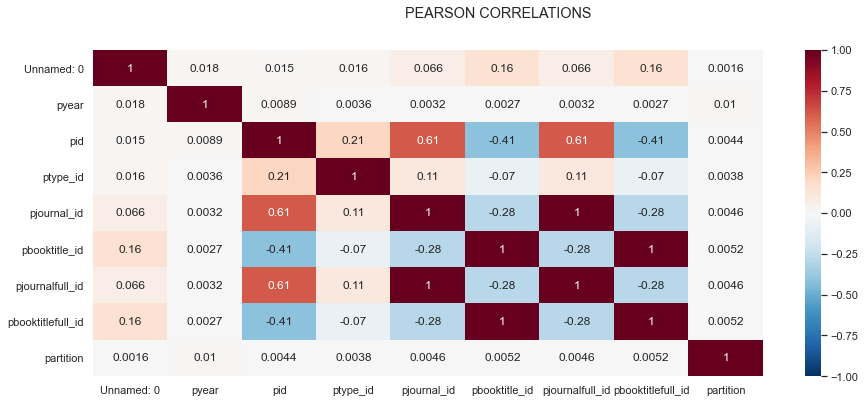

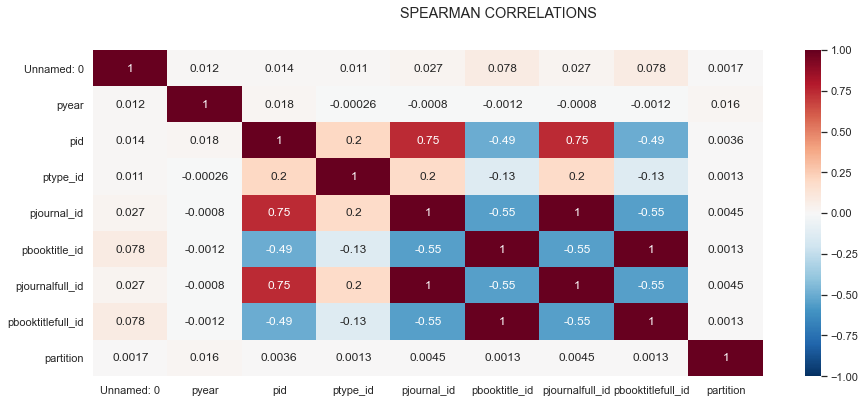

In [22]:
quick_eda(df)

#### Boxplots

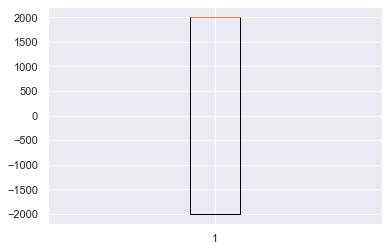

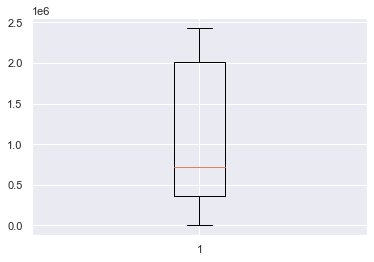

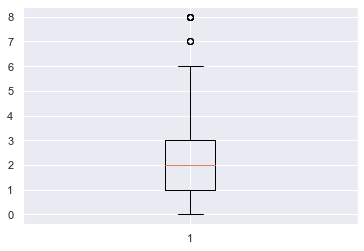

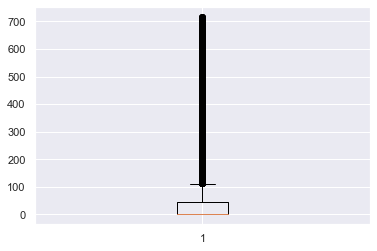

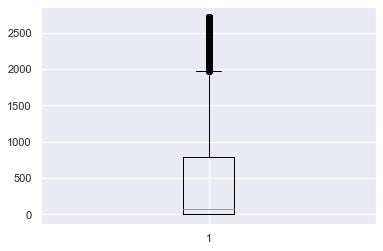

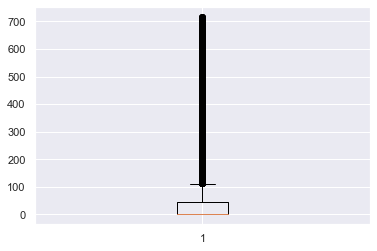

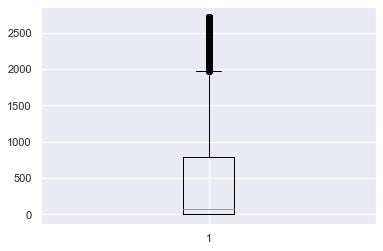

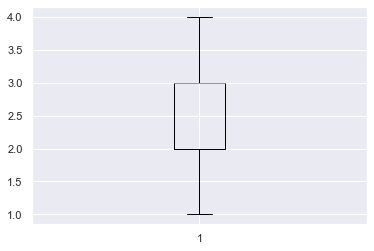

In [24]:
for i in ['pyear','pid','ptype_id','pjournal_id','pbooktitle_id','pjournalfull_id','pbooktitlefull_id','partition']:
    plt.boxplot(df[i])
    plt.show()
    

##### Histograms

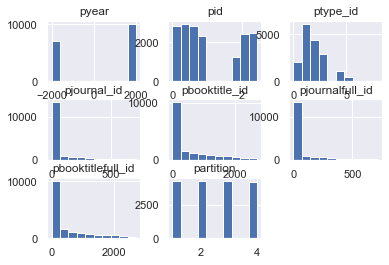

In [32]:
df[['pyear','pid','ptype_id','pjournal_id','pbooktitle_id','pjournalfull_id','pbooktitlefull_id','partition']].hist()
plt.title("Distributions revenue columns")
#plt.legend([l for l in ['pyear','pid','ptype_id','pjournal_id','pbooktitle_id','pjournalfull_id','pbooktitlefull_id','partition']])
plt.show()

In [33]:
#import nltk
#from nltk.corpus import stopwords
#stop = stopwords.words('english')

In [ ]:
#df[''] = df[''].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#df[''].head()

In [56]:
# Tokenizing words
#words= nltk.word_tokenize(df['ptitle'])

##### We lowercase the words by using the lower() function

In [54]:
df['cleaned_title']=df['ptitle'].apply(lambda x: x.lower())
df['cleaned_author']=df['pauthor'].apply(lambda x: x.lower())

##### Remove Punctuations

In [55]:
df['cleaned_title']=df['cleaned_title'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['cleaned_author']=df['cleaned_author'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))


##### Translate words